*First compiled on May 5th, 2017.*

# Scanpy analysis of 3k PBMCs following a Seurat Tutorial

Among other possibilties, Scanpy allows to reproduce Seurat's standard workflow as described on http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017). Thanks to the Seurat authors for this beautiful tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3                # verbosity = 2: errors, warnings, info, hints
sc.settings.set_figure_params(dpi=70)    # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy 0.3 on 2017-11-17 02:09.


In [2]:
path = './data/pbmc3k_filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).transpose()
adata.var_names = np.genfromtxt(path + 'genes.tsv', dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(path + 'barcodes.tsv', dtype=str)

reading cache ./write/data/pbmc3k_filtered_gene_bc_matrices/hg19/matrix.h5


Basic filtering.

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Plot some information about mitochondrial genes, important for quality control

In [4]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('MT-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

A violin plot of the computed quality measures.

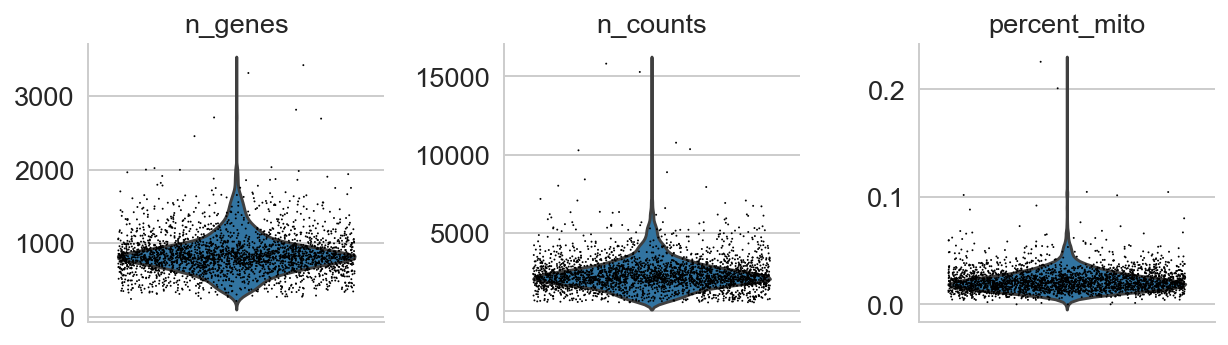

In [5]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                   jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

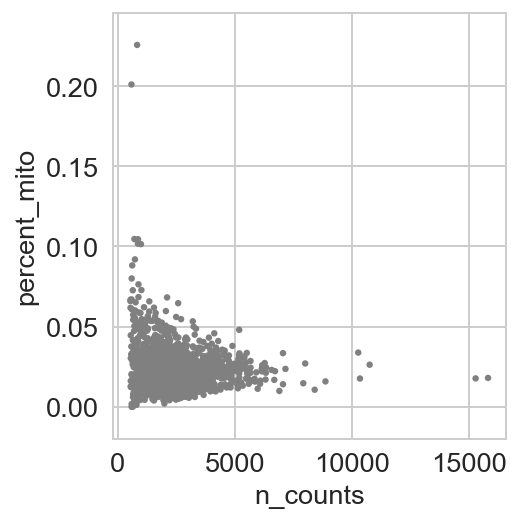

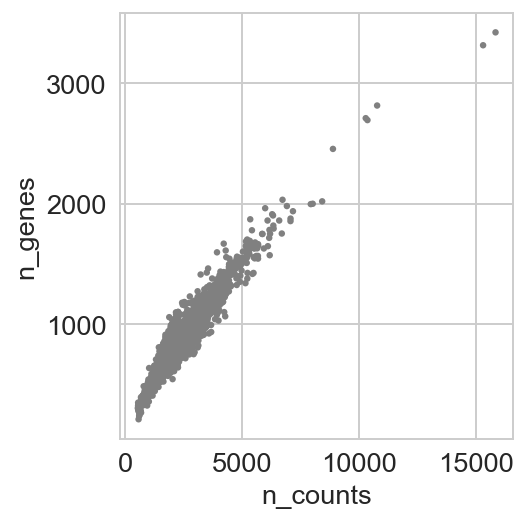

In [6]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [7]:
type(adata.smp['n_genes'] < 2500)

pandas.core.series.Series

In [8]:
adata = adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]

Save the logarithmized raw gene expression for later use in differential testing.

In [9]:
sc.write('pbmc3k_filtered_raw_log', sc.pp.log1p(adata, copy=True))

Per-cell normalize the data matrix $X$, identify highly-variable genes and compute logarithm.

normalizing by total count per cell
    finished (0:00:00.050): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.smp)
filter highly variable genes by dispersion and mean (0:00:00.130)
--> set `n_top_genes` to simply select top-scoring genes instead


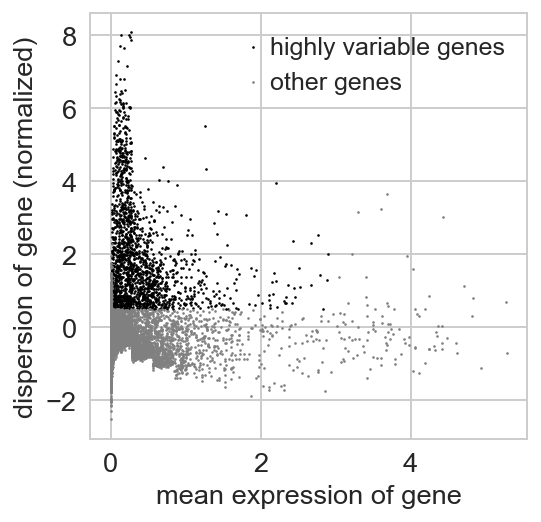

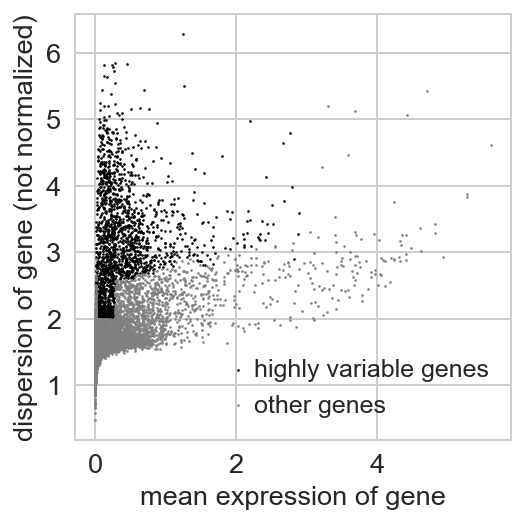

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering and logarithmize the data.

In [11]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [12]:
adata_corrected = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'],
                                    copy=True)


--> after `sc.pp.regress_out`, consider rescaling the adata using `sc.pp.scale`


In [13]:
sc.pp.scale(adata_corrected, max_value=10)

Save the result.

In [14]:
sc.write('pbmc3k_corrected', adata_corrected)

### PCA

Compute PCA and make a scatter plot.

In [15]:
sc.tl.pca(adata_corrected)

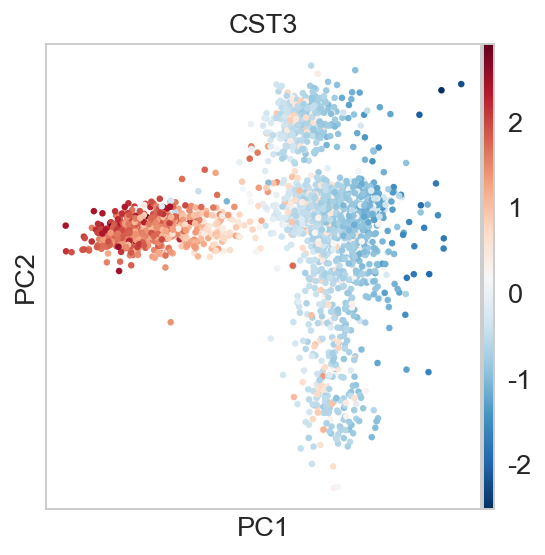

In [16]:
adata_corrected.smpm['X_pca'] *= -1  # multiply by -1 to match Seurat R
ax = sc.pl.pca_scatter(adata_corrected, color='CST3', right_margin=0.2, color_map='RdBu_r')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

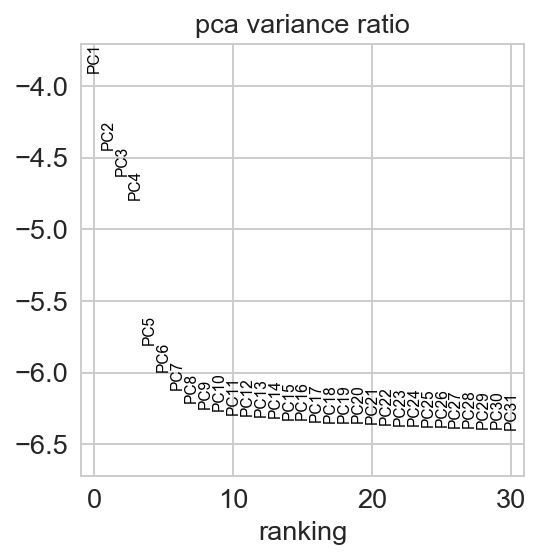

In [17]:
sc.pl.pca_variance_ratio(adata_corrected, log=True)

### tSNE

In [18]:
adata_corrected = sc.read('pbmc3k_corrected')

In [19]:
sc.tl.tsne(adata_corrected, n_pcs=10, random_state=2)

computing tSNE
    preprocess using PCA with 10 PCs
--> avoid this by setting n_pcs = 0
    using 10 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:07.934):  added
    "X_tsne", tSNE coordinates (adata.smp)


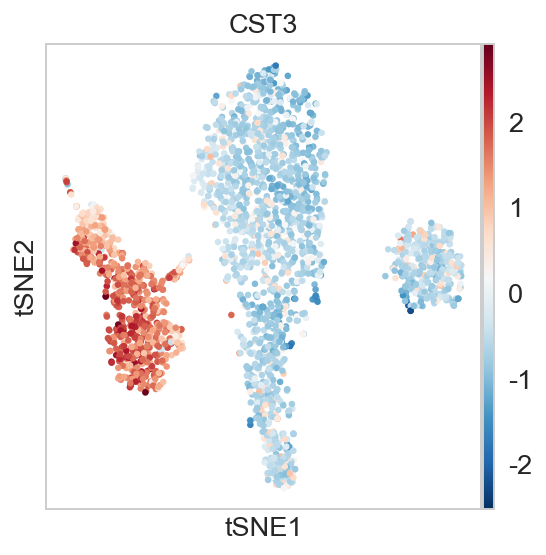

In [20]:
ax = sc.pl.tsne(adata_corrected, color='CST3', color_map='RdBu_r')

In [21]:
sc.write('pbmc3k_corrected', adata_corrected)

### Clustering

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.04).

In [22]:
adata_corrected = sc.read('pbmc3k_corrected')

In [23]:
sc.tl.louvain(adata_corrected, n_neighbors=10, resolution=1.3, recompute_graph=True)

running Louvain clustering
    compute "X_pca" for building graph
    computing data graph with n_neighbors = 10 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9938759804  0.9874853492  0.9716261625  0.9538829923
      0.9355867505  0.9228008389  0.8264053464  0.8115137219  0.7480960488
      0.7456020117  0.7311634421  0.7090933919  0.7047501802  0.6949557662]
    using the "louvain" package of Traag (2017)
    finished (0:00:01.451): found 8 clusters and added
    'louvain_groups', the cluster labels (adata.smp, dtype=category)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

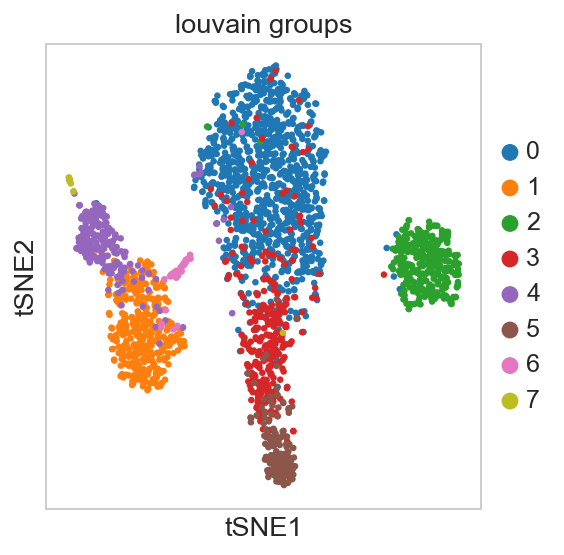

In [24]:
ax = sc.pl.tsne(adata_corrected, color='louvain_groups')

Save this, in case we need it later.

In [25]:
sc.write('pbmc3k_corrected', adata_corrected)

### Find marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes by z-score, this agrees quite well with the more advanced tests of Seurat.

For this, we should always use the logarithmized raw data.

find differentially expressed genes
... consider 'louvain_groups': ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1110  417  340  328  219  166   42   16]
    finished (0:00:00.872) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.uns)
    "rank_genes_groups_gene_zscores", the scores (adata.uns)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


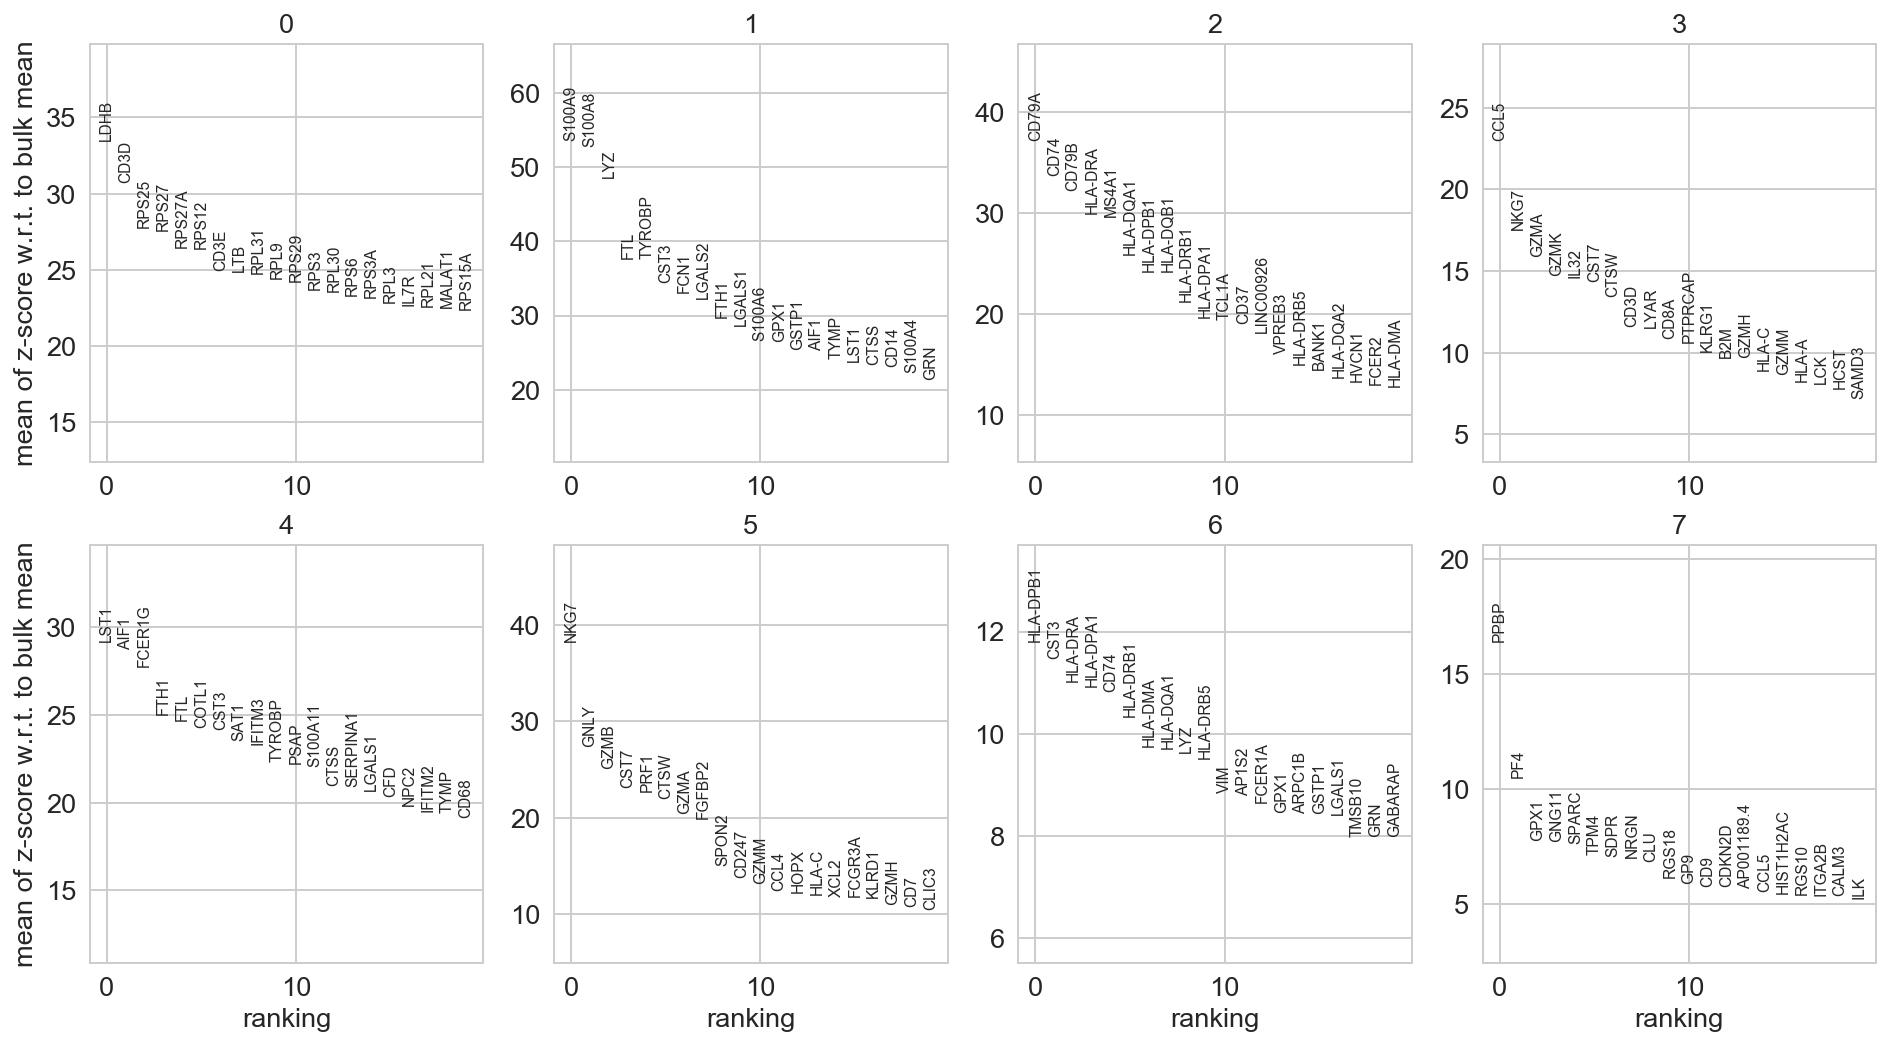

In [26]:
adata_corrected = sc.read('pbmc3k_corrected')
adata_raw = sc.read('pbmc3k_filtered_raw_log')
adata_raw.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups')
sc.pl.rank_genes_groups(adata_raw, n_genes=20)

Show the 20 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [27]:
import pandas as pd
pd.DataFrame(adata_raw.add['rank_genes_groups_gene_names']).loc[:20]

,0,1,2,3,4,5,6,7
0,LDHB,S100A9,CD79A,CCL5,LST1,NKG7,HLA-DPB1,PPBP
1,CD3D,S100A8,CD74,NKG7,AIF1,GNLY,CST3,PF4
2,RPS25,LYZ,CD79B,GZMA,FCER1G,GZMB,HLA-DRA,GPX1
3,RPS27,FTL,HLA-DRA,GZMK,FTH1,CST7,HLA-DPA1,GNG11
4,RPS27A,TYROBP,MS4A1,IL32,FTL,PRF1,CD74,SPARC
5,RPS12,CST3,HLA-DQA1,CST7,COTL1,CTSW,HLA-DRB1,TPM4
6,CD3E,FCN1,HLA-DPB1,CTSW,CST3,GZMA,HLA-DMA,SDPR
7,LTB,LGALS2,HLA-DQB1,CD3D,SAT1,FGFBP2,HLA-DQA1,NRGN
8,RPL31,FTH1,HLA-DRB1,LYAR,IFITM3,SPON2,LYZ,CLU
9,RPL9,LGALS1,HLA-DPA1,CD8A,TYROBP,CD247,HLA-DRB5,RGS18


Even though the ranking by z-scores is a very simple procedure, the resulting genes agree very well with the marker genes fround by Seurat. With the exception of the marker genes of group 4, all marker genes mentioned in the [Seurat Tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) can be found the rankings, and one can hence identify the cell types.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 |	GNLY, NKG7 | 	NK cells
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Save the result.

In [28]:
sc.write('pbmc3k_filtered_raw_log', adata_raw)

Compare to a single cluster. 

find differentially expressed genes
... consider 'louvain_groups': ['0' '1'] with sample numbers [1110  417]
    finished (0:00:00.084) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.uns)
    "rank_genes_groups_gene_zscores", the scores (adata.uns)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


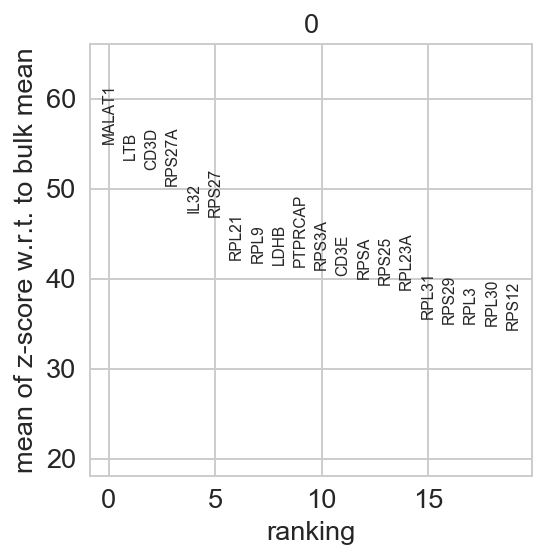

In [29]:
adata_corrected = sc.read('pbmc3k_corrected')
adata_raw = sc.read('pbmc3k_filtered_raw_log')
adata_raw.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups', groups=['0'], group_reference='1')
sc.pl.rank_genes_groups(adata_raw, groups=['0'], n_genes=20)

If you want to compare a certain gene across groups, use the following.

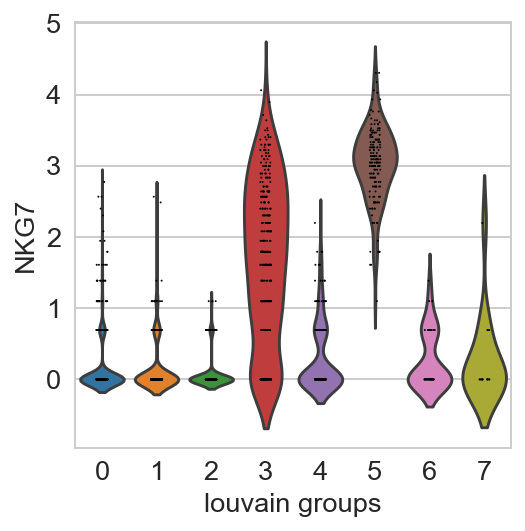

In [30]:
ax = sc.pl.violin(adata_raw, 'NKG7', group_by='louvain_groups')

If we want a more detailed view for a certain group, use the following function, you need to pass `compute_distribution=True` for this.

find differentially expressed genes
... consider 'louvain_groups': ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1110  417  340  328  219  166   42   16]
    finished (0:00:04.467) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.uns)
    "rank_genes_groups_gene_zscores", the scores (adata.uns)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


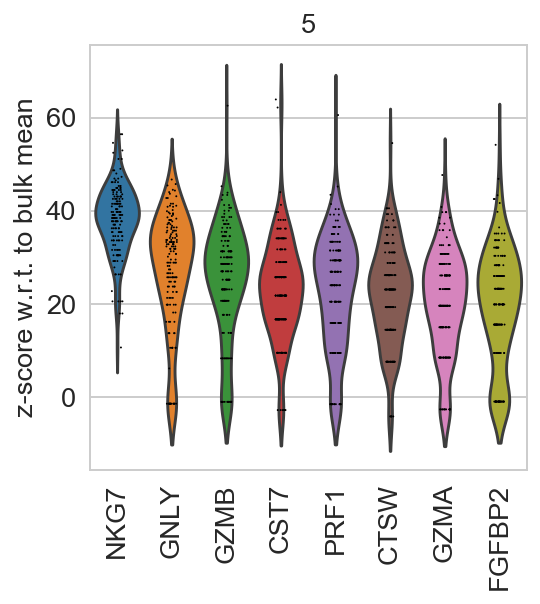

In [31]:
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups', compute_distribution=True)
ax = sc.pl.rank_genes_groups_violin(adata_raw, groups='5', n_genes=8)

Actually mark the cell types.

In [32]:
adata_corrected = sc.read('pbmc3k_corrected')
adata_corrected.smp['louvain_groups'].cat.categories = [
    "CD4 T cells", "CD14+ Monocytes", 
    "B cells", "CD8 T cells", 
    "FCGR3A+ Monocytes", "NK cells",
    "Dendritic cells", "Megakaryocytes"]
sc.write('pbmc3k_corrected', adata_corrected)

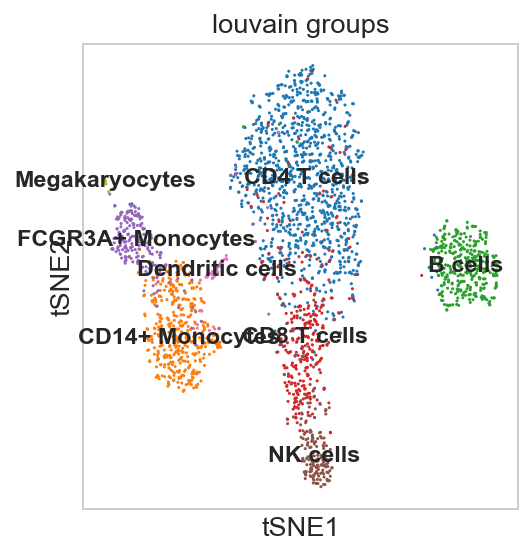

In [33]:
adata_corrected = sc.read('pbmc3k_corrected')
axs = sc.pl.tsne(adata_corrected, size=10,
                 legend_fontsize=12, legend_fontweight='bold',
                 color='louvain_groups',
                 legend_loc='on data')

Consider saving using compression to save diskspace.

In [34]:
sc.write('pbmc3k_corrected', adata_corrected, compression='gzip')

If you want to export to "csv", you will usually use pandas.

In [35]:
adata_corrected = sc.read('pbmc3k_corrected')

In [36]:
adata_corrected.smp[['n_counts', 'louvain_groups']].to_csv(
    './write/pbmc3k_corrected_louvain_groups.csv')

In [37]:
adata_corrected.smpm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/pbmc3k_corrected_X_pca.csv')

Or export everything using `sc.write`.

In [38]:
sc.write('./write/pbmc3k_corrected.csv', adata_corrected)

writing csv files to ./write/pbmc3k_corrected/
